In [3]:
import numpy as np
import os
import cv2

from datetime import datetime

from sklearn.model_selection import train_test_split

from keras import mixed_precision
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, BackupAndRestore, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from plot_history_lib import plot_history, plot_precision_recall, plot_confusion_matrix
from models_lib import MiniVGGModel

# ETL

## Підготовка даних CIFAR-10

In [6]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

**Підготовка тренувальних даних котів і собак**

In [7]:
folder_path_train = "cat_dog/train"

current_directory = os.getcwd()
full_path_train = os.path.normpath(os.path.join(current_directory, folder_path_train))

train_images = []
train_labels = []
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def resize_image(img):
    return cv2.resize(img, (32, 32))

num_dogs = 0
num_cats = 0
target_images = 1000

for filename in os.listdir(full_path_train):
    if filename.endswith(".jpg"):
        image_path = os.path.join(full_path_train, filename)
        img = cv2.imread(image_path)
        img = resize_image(img)

        label = filename.split(".")[0]
        if label == "cat" and num_cats < target_images / 2:
            train_images.append(img)
            train_labels.append(class_names.index("cat"))
            num_cats += 1
        elif label == "dog" and num_dogs < target_images / 2:
            train_images.append(img)
            train_labels.append(class_names.index("dog"))
            num_dogs += 1

        if num_cats + num_dogs == target_images:
            break

**Розширення тренувального набору даних та підготовка до навчання**

In [8]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
train_labels = train_labels.reshape(-1, 1)

X_train = np.concatenate((X_train, train_images), axis=0)
y_train = np.concatenate((y_train, train_labels), axis=0)

In [9]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
y_valid = to_categorical(y_valid, num_classes=10)

In [10]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

size_dataset = X_train.shape[0]
size_test_dataset = X_test.shape[0]
size_vall_dataset = X_valid.shape[0]

batch_size = 128

# EDA
**Налаштування генераторів даних для тренування, тестування та валідації**

In [11]:
mixed_precision.set_global_policy("mixed_bfloat16")

In [12]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.12,
    height_shift_range=0.12,
    shear_range=10,
)

test_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
test_generator = test_datagen.flow(X_test, y_test, batch_size=batch_size)
validation_generator = valid_datagen.flow(X_valid, y_valid, batch_size=batch_size)

**Налаштування ранньої зупинки, резервного копіювання та відновлення, зменшення швидкості навчання та журналування з TensorBoard**

In [17]:
folder_backup = "backup"
folder_log = "log/fit"

folder_path_backup = os.path.normpath(os.path.join(current_directory, folder_backup))
folder_path_log = os.path.normpath(os.path.join(current_directory, folder_log))

early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True, start_from_epoch=10, verbose=1)

backup = BackupAndRestore(backup_dir=folder_path_backup, save_freq=5, delete_checkpoint=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.98, patience=25, min_lr=0.00045)

log_dir = folder_path_log + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Навчання:

In [ ]:
filtermodel = MiniVGGModel()
model_filter = filtermodel.build()
history = model_filter.fit(
    train_generator,
    epochs=500,
    validation_data=validation_generator,
    callbacks=[early_stopping, backup, tensorboard, reduce_lr]
)

**Візуалізація історії навчання:**

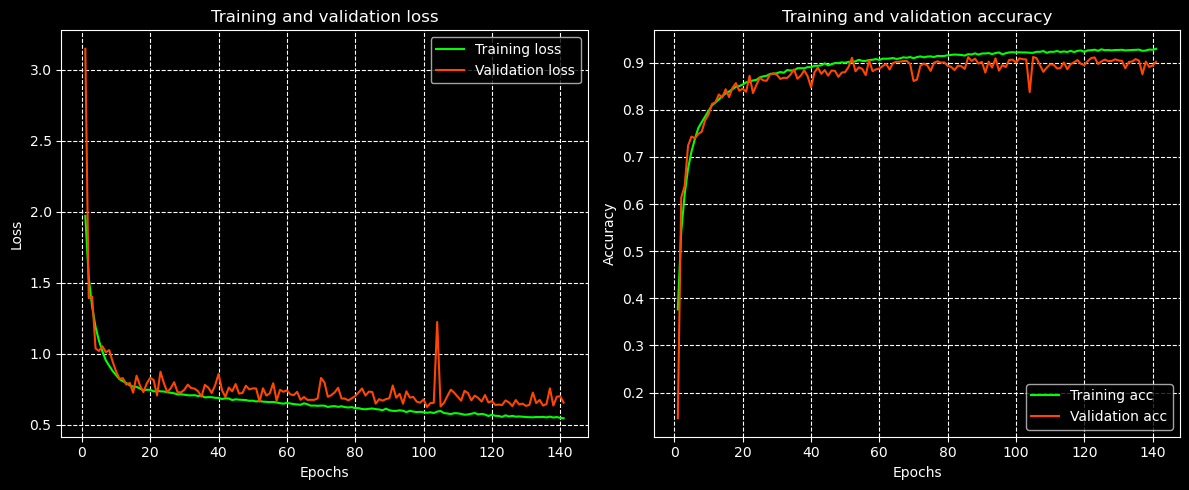

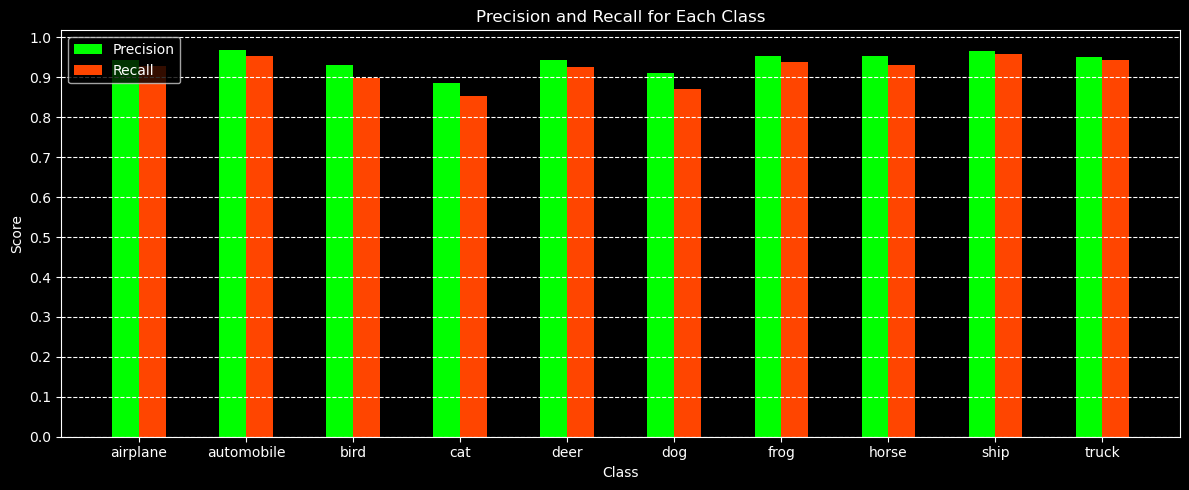

In [11]:
plot_history(history)
plot_precision_recall(history, class_names)


**Оцінка точності моделі**

In [ ]:
test_acc = model_filter.evaluate(test_generator)
print("test acc:", test_acc[1])

In [13]:
y_pred_prob = model_filter.predict(X_test/255.)
y_pred = np.argmax(y_pred_prob, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


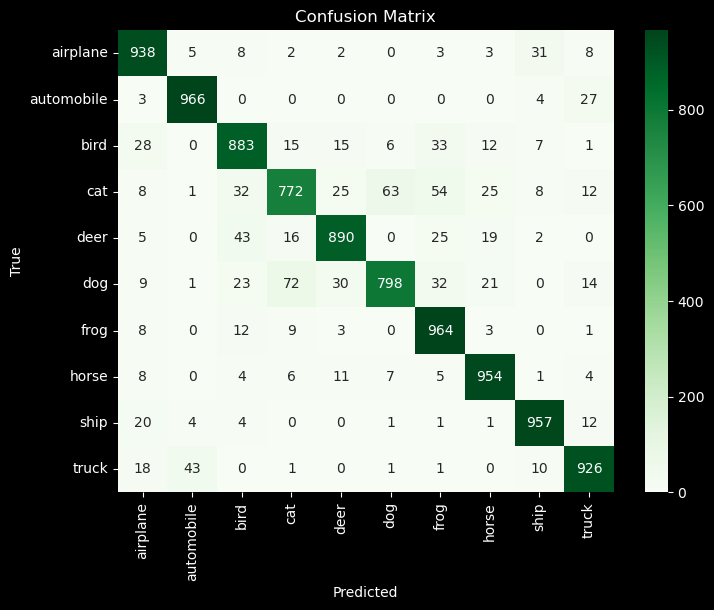

In [14]:
plot_confusion_matrix(y_test, y_pred, class_names)

In [ ]:
folder_save = "trained_models"
time = datetime.now().strftime("%Y%m%d-%H%M%S")
name_file = f"model_cifar10_vgg4_{time}.keras"

folder_path_save = os.path.normpath(os.path.join(current_directory, folder_save, name_file))

model_filter.save(folder_path_save)